In [1]:
# Downgrade OpenCV
#!pip uninstall opencv-python -y
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!wget https://raw.githubusercontent.com/ramilsafnab1996/computer-vision-courses-2018/master/Panorama%20Stitching/images/panorama-left.jpg
!wget https://raw.githubusercontent.com/ramilsafnab1996/computer-vision-courses-2018/master/Panorama%20Stitching/images/panorama-right.jpg

--2020-12-28 20:58:15--  https://raw.githubusercontent.com/ramilsafnab1996/computer-vision-courses-2018/master/Panorama%20Stitching/images/panorama-left.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164789 (161K) [image/jpeg]
Saving to: ‘panorama-left.jpg.6’

panorama-left.jpg.6 100%[===================>] 160.93K  --.-KB/s    in 0.03s   

2020-12-28 20:58:16 (4.70 MB/s) - ‘panorama-left.jpg.6’ saved [164789/164789]

--2020-12-28 20:58:16--  https://raw.githubusercontent.com/ramilsafnab1996/computer-vision-courses-2018/master/Panorama%20Stitching/images/panorama-right.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|15

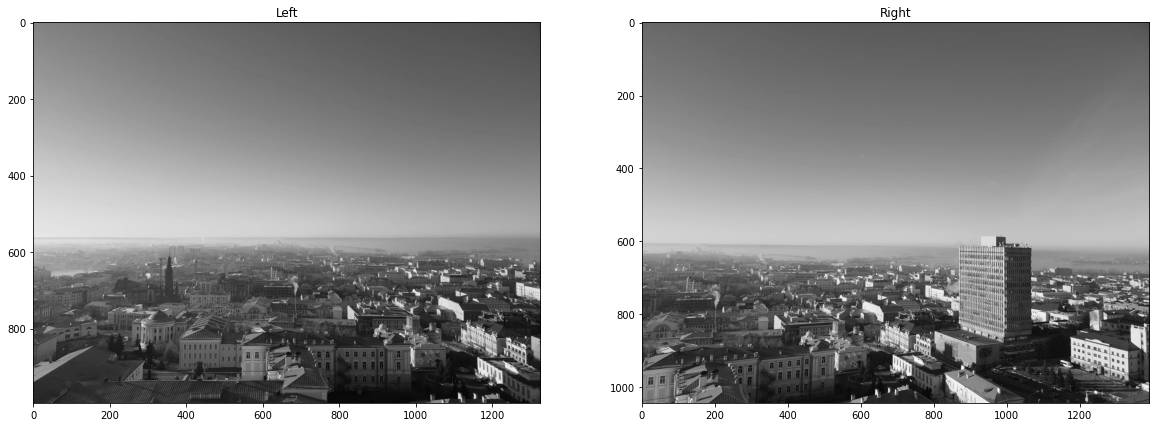

In [4]:
left_img  = cv2.cvtColor(cv2.imread('panorama-left.jpg'), cv2.COLOR_BGR2GRAY)
right_img = cv2.cvtColor(cv2.imread('panorama-right.jpg'), cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20, 20))

plt.subplot(121)
plt.imshow(left_img, 'gray')
plt.title('Left')

plt.subplot(122)
plt.imshow(right_img, 'gray')
plt.title('Right')

plt.show()

In [5]:
# SURF
detector = cv2.xfeatures2d.SURF_create(hessianThreshold=200, extended=True, upright=False)

left_keypoints, left_desc = detector.detectAndCompute(left_img, None)
right_keypoints, right_desc = detector.detectAndCompute(right_img, None)

print("Keypoints found (left image): ", left_desc.shape)
print("Keypoints found (right image): ", right_desc.shape)

Keypoints found (left image):  (4651, 128)
Keypoints found (right image):  (6211, 128)


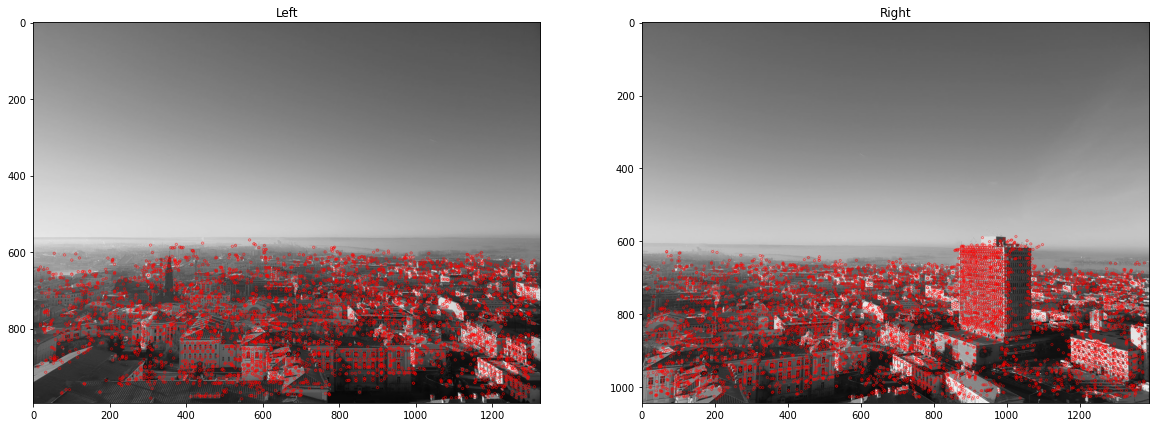

In [6]:
# Draw keypoints
left_img_with_keypoints = cv2.drawKeypoints(left_img, left_keypoints, None, (255,0,0), 2)
right_img_with_keypoints = cv2.drawKeypoints(right_img, right_keypoints, None, (255,0,0), 2)

plt.figure(figsize=(20, 20))

plt.subplot(121)
plt.imshow(left_img_with_keypoints, 'gray')
plt.title('Left')

plt.subplot(122)
plt.imshow(right_img_with_keypoints, 'gray')
plt.title('Right')

plt.show()

In [7]:
# Match keypoints (brute-force)
matcher = cv2.BFMatcher()
initial_matches = matcher.knnMatch(left_desc, right_desc, k=2)

print("Keypoint matches: {}".format(len(initial_matches)))

# Filter them out by ratio (Lowe's test)
matches = []
ratio = 0.7
for (m, n) in initial_matches:
  if m.distance < ratio * n.distance:
    matches.append(m)

print("Keypoint matches (Lowe's): {}".format(len(matches)))

Keypoint matches: 4651
Keypoint matches (Lowe's): 675


In [8]:
# Match
print(matches[0].queryIdx) # left feature's index
print(matches[0].trainIdx) # right feature's index
print(matches[0].distance) # distance computed for the left and right features (using corresponding descriptors)

2
22
0.21606385707855225


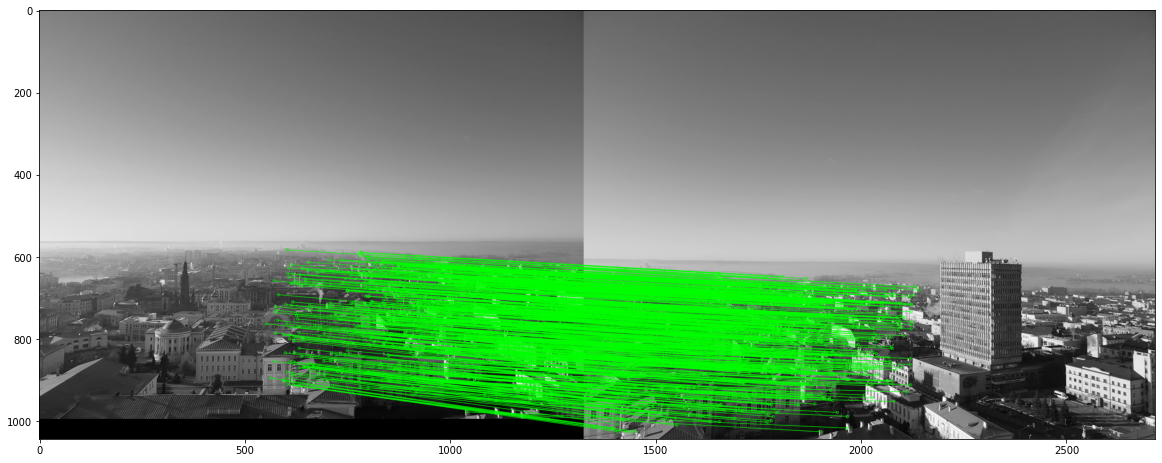

In [9]:
# left and right features coordinates (x, y)
left_points = np.float32([left_keypoints[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
right_points = np.float32([right_keypoints[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# finds a perspective transformation H b/w 2 planes (represented by a set of feature points)
# inliers_mask is created by the RANSAC method
# ones - inliers, zeros - outliers
# outlier points SHOULD NOT be considered as good feature matches
H, inliers_mask = cv2.findHomography(right_points, left_points, cv2.RANSAC, 5.0)
inliers_mask = inliers_mask.ravel().tolist()

# draw inlier matches: left and right images side-by-side and matched features connected by lines
h, w = left_img.shape
points = np.float32([[0, 0],[0, h - 1],[w - 1, h - 1],[w - 1, 0]]).reshape(-1, 1, 2)
result = cv2.perspectiveTransform(points, H)
draw_params = dict(
    matchColor = (0,255,0),
    singlePointColor = None,
    matchesMask = inliers_mask,
    flags = 2
)
img_matches = cv2.drawMatches(
    left_img, left_keypoints,
    right_img, right_keypoints,
    matches, None, **draw_params
)
plt.figure(figsize=(20, 20))
plt.imshow(img_matches)
plt.show()

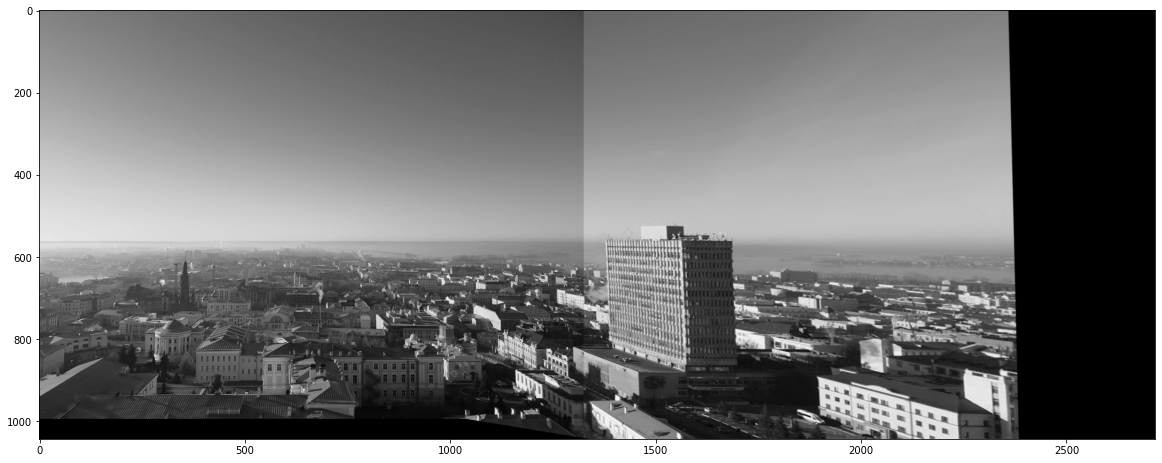

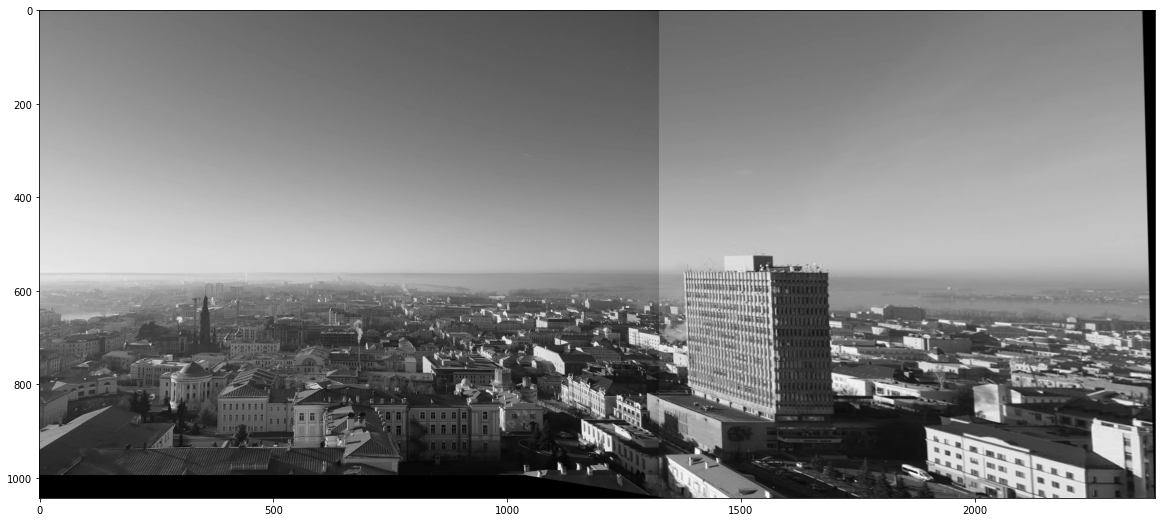

In [10]:
left_height, left_width = left_img.shape
right_height, right_width = right_img.shape

panorama_height = max(left_height, right_height)
panorama_width = left_width + right_width

# create a panorama image
result = cv2.warpPerspective(right_img, H, (panorama_width, panorama_height))
result[0:left_height, 0:left_width] = left_img

# visualize the panorama image (it can be with black borders)
plt.figure(figsize=(20, 20))
plt.imshow(result, cmap='gray')
plt.show()

# crop black borders
_, contours, _ = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(max(contours, key = len))
plt.figure(figsize=(20, 20))
plt.imshow(result[y:y+h,x:x+w], cmap='gray')
plt.show()